In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

Celem analizy jest odkrycie zależności między uwarunkowaniami biologicznymi koszykarzy a statystykami dotyczącymi ich gry w NBA. Zweryfikowane też zostaną hipotezy, które zostaną postawione w dalszej części.

Do warunków biologicznych można zaliczyć kilka czynników, takich jak wiek, wzrost, waga, czy pochodzenie. Tutaj zostaną wzięte pod uwagę dwa pierwsze, a więc wiek i wzrost. Można spodziewać się, że wpływają one na grę zawodnika w sposób dużo bardziej odczuwalny niż waga czy wzrost. Co więcej, waga zawodnika nie mówi nic o jego dyspozycji fizycznej (nie wiadomo, czy zawodnik jest bardzo muskularny czy bardzo otyły). Z tego powodu w analizie zostaną rozpatrzone jedynie wiek i wzrost zawodników.

Przedmiotem analizy będą statystyki z 23 kompletnych sezonów w XXI wieku, począwszy od sezonu 1999-2000 aż do sezonu 2021-2022. W tym czasie sezon NBA rozegrało łącznie 2252 zawodników.

Dla każdego sezonu dostępne są cztery rodzaje danych, które można w swobodny sposób dobierać do analizowanego czynnika:

-dane osobiste zawodników (wiek, wzrost, waga...)

-statystyki łączne w sezonie

-statystyki średnie na mecz

-statystyki średnie na minutę

Dane zostały zescrapowane przy użyciu biblioteki BeautifulSoup ze strony https://basketball.realgm.com.

    Przygotowanie danych

Pobrane dane wyrażały wzrost zawodników w systemie amerykańskim (stopy, cale). Przed analizą wzrost zawodników został przekonwertowany do jednostki centymetrowej, z której powszechnie korzysta się w Europie.

In [2]:
def convert_to_cm(height):
    CENTIMETERS_IN_FOOT = 30.48
    CENTIMETERS_IN_INCH = 2.54
    feet, inches = height.split('-')
    total_cm = CENTIMETERS_IN_FOOT * int(feet) + CENTIMETERS_IN_INCH * int(inches)
    return round(total_cm, 1)

def convert_to_kg(weight):
    KILOGRAMS_IN_POUND = 0.4536
    return round(KILOGRAMS_IN_POUND * int(weight), 1)

In [3]:
dataframes = {}
YEAR_FROM = 2000
YEAR_TO = 2022

for year in range(YEAR_FROM, YEAR_TO + 1):
    bios_file = f'DataFrames\\Bios\\bios_{year}.csv'
    bios = pd.read_csv(bios_file, index_col='Player')
    bios = bios.drop('GP', axis=1)
    bios['HT'] = bios['HT'].apply(convert_to_cm)
    bios['WT'] = bios['WT'].apply(convert_to_kg)
    dataframes["bios", year] = bios

    totals_file = f'DataFrames\\Totals\\totals_{year}.csv'
    totals = pd.read_csv(totals_file, index_col='Player')
    dataframes["totals", year] = totals

    per_game_file = f'DataFrames\\Averages\\averages_{year}.csv'
    per_game = pd.read_csv(per_game_file, index_col='Player')
    dataframes["per_game", year] = per_game

    per_minute_file = f'DataFrames\\PerMinute\\per_minute_{year}.csv'
    per_minute = pd.read_csv(per_minute_file, index_col='Player')
    dataframes["per_minute", year] = per_minute

Liczba koszykarzy dla każdego sezonu i każdej ramki danych:

In [4]:
years = list(range(YEAR_FROM, YEAR_TO+1))
presentation = pd.DataFrame({'bios': {year: dataframes["bios", year].shape[0] for year in years},
                            'totals': {year: dataframes["totals", year].shape[0] for year in years},
                            'per_game': {year: dataframes["per_game", year].shape[0] for year in years},
                            'per_minute': {year: dataframes["per_minute", year].shape[0] for year in years},
                            })
display(presentation)

,bios,totals,per_game,per_minute
2000,439,439,439,439
2001,441,441,441,441
2002,440,440,440,440
2003,428,428,428,428
2004,442,442,442,442
2005,464,464,464,464
2006,458,458,458,458
2007,458,458,458,458
2008,451,451,451,451
2009,445,445,445,445


Łączna liczba analizowanych koszykarzy:

In [5]:
all_players_all_seasons = pd.concat([dataframes["bios", year] for year in years])
unique_players = all_players_all_seasons.reset_index().drop_duplicates(subset=all_players_all_seasons.index.name).set_index("Player")
display(len(unique_players))

2252

W celu łatwiejszego operowania na danych, poniższe komórki tworzą ramki danych dla każdej kategorii złożone z wszystkich sezonów (jeden rekord dla każdego zawodnika w każdym sezonie)

In [6]:
all_seasons_totals = pd.merge(dataframes["bios", YEAR_FROM], dataframes["totals", YEAR_FROM], on='Player')
for year in range(YEAR_FROM + 1, YEAR_TO + 1):
    all_seasons_totals = pd.concat([all_seasons_totals, pd.merge(dataframes["bios", year], dataframes["totals", year], on='Player')])
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", 5)
display(all_seasons_totals)

,Pos,HT,...,TOV,PF
Player,,,,,
Tariq Abdul-Wahad,SF,198.1,...,106,147
Shareef Abdur-Rahim,F,205.7,...,249,244
...,...,...,...,...,...
Cody Zeller,F,210.8,...,19,56
Ivica Zubac,C,213.4,...,114,203


In [7]:
all_seasons_per_game = pd.merge(dataframes["bios", YEAR_FROM], dataframes["per_game", YEAR_FROM], on='Player')
for year in range(YEAR_FROM + 1, YEAR_TO + 1):
    all_seasons_per_game = pd.concat([all_seasons_per_game, pd.merge(dataframes["bios", year], dataframes["per_game", year], on='Player')])
display(all_seasons_per_game)

,Pos,HT,...,TOV,PF
Player,,,,,
Tariq Abdul-Wahad,SF,198.1,...,1.7,2.4
Shareef Abdur-Rahim,F,205.7,...,3.0,3.0
...,...,...,...,...,...
Cody Zeller,F,210.8,...,0.7,2.1
Ivica Zubac,C,213.4,...,1.5,2.7


In [8]:
all_seasons_per_minute = pd.merge(dataframes["bios", YEAR_FROM], dataframes["per_minute", YEAR_FROM], on='Player')
for year in range(YEAR_FROM + 1, YEAR_TO + 1):
    all_seasons_per_minute = pd.concat([all_seasons_per_minute, pd.merge(dataframes["bios", year], dataframes["per_minute", year], on='Player')])
display(all_seasons_per_minute)

,Pos,HT,...,TOV,PF
Player,,,,,
Tariq Abdul-Wahad,SF,198.1,...,0.1,0.1
Shareef Abdur-Rahim,F,205.7,...,0.1,0.1
...,...,...,...,...,...
Cody Zeller,F,210.8,...,0.1,0.2
Ivica Zubac,C,213.4,...,0.1,0.1


Przy analizie danych w większości przypadków będzie wykorzystywana funkcja normalizująca w celu zwiększenia wiarygodności wyników. Rozpatrując daną kategorię (wiek/wzrost), funkcja usuwa te zakresy, dla których nie ma wystarczająco dużej liczby koszykarzy. Dolną granicą w dalszej analizie będzie 50 zawodników w danej kategorii.

In [11]:
def get_normalized_dataframe(dframe, minimum = 50):
    mask = dframe.count() <= minimum
    return dframe.drop(columns=dframe.columns[mask])

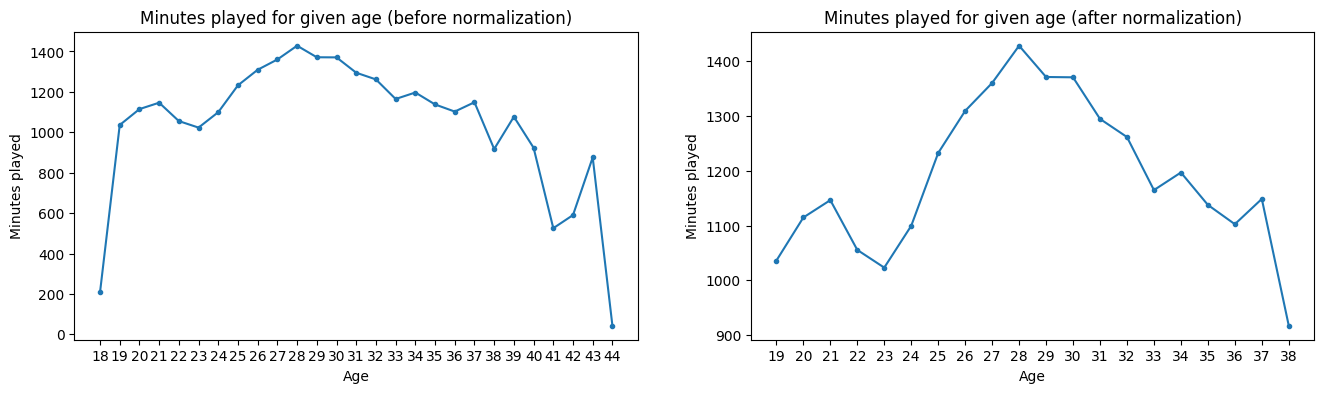

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

total_minutes_to_age = pd.pivot_table(all_seasons_totals, values='MIN', index='Player', columns='Age')
avrg_total_minutes_to_age = total_minutes_to_age.mean()
ax[0].plot(avrg_total_minutes_to_age.index, avrg_total_minutes_to_age.values, label='Average minutes played in a season',  marker='.')
ax[0].set_title('Minutes played for given age (before normalization)')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Minutes played')
ax[0].set_xticks(avrg_total_minutes_to_age.index)

total_minutes_to_age = get_normalized_dataframe(total_minutes_to_age)
avrg_total_minutes_to_age = total_minutes_to_age.mean()
ax[1].plot(avrg_total_minutes_to_age.index, avrg_total_minutes_to_age.values, label='Average minutes played in a season',  marker='.')
ax[1].set_title('Minutes played for given age (after normalization)')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Minutes played')
ax[1].set_xticks(avrg_total_minutes_to_age.index)

plt.show()

Powyżej na lewym wykresie, korzystającym z danych przed normalizacją, odnotowano gwałtowny wzrost średniej liczby rozegranych minut na sezon w wieku 43 lat. Średnia ta jest porównywalna z liczbą minut dla wieku 38, a więc dla zawodników o 5 lat młodszych. Jest to spowodowane faktem, że tylko jeden zawodnik w historii NBA rozegrał sezon w tym wieku - był to Vince Carter, który w sezonie 2019-20, w wieku 43 lat, rozegrał ponad 875 minut w 60 meczach.

Funkcja normalizująca odrzuca kolumny o zbyt małej liczbie danych. Tak przerobiona ramka danych jest przedstawiona na prawym wykresie - przedstawione są statystyki tylko dla tych wieków zawodników, w jakich przynajmniej 50 zawodników w historii NBA rozegrało sezon.

Oczywiście wykres nie pokazuje jeszcze w pełni wyraźnie, że z upływem lat zawodnik rozgrywa coraz mniej minut - wciąż można zaobserwować wzrost tej liczby w wieku 34 i 37 lat, mimo normalizacji. Jest to spowodowane tym, że najstarsi zawodnicy w lidze są często wartościowi dla zespołu mimo obniżonych zdolności fizycznych (w przeciwnym wypadku byliby już prawdopodobnie na emeryturze). Stąd mimo że fizyczna wydajność zawodników spada z wiekiem, zawodnicy tacy jak Dirk Nowitzki, Karl Malone, Michael Jordan, czy Tim Duncan wciąż byli w stanie osiągnąć ponad 60 meczy w sezonie w wieku 39 lat (nie bez powodu każdy z wymienionych był nagradzany nagrodą MVP i był ponad 10 razy wybierany do NBA All-Star)

    Analiza danych  

    Zależność liczby meczy i minut od wieku

Pierwszą hipotezą związaną z wiekiem jest jego silna korelacja z dyspozycją fizyczną zawodników. W większości dyscyplin około 30 roku życia zawodnicy przeżywają szczyt swojej formy, która do końca kariery spada. Można się więc spodziewać, że do około 30 roku życia średnia liczba meczy w sezonie i minut na mecz będzie rosnąć, a po osiągnięciu maksimum z roku na rok będzie maleć aż do zakończenia kariery.

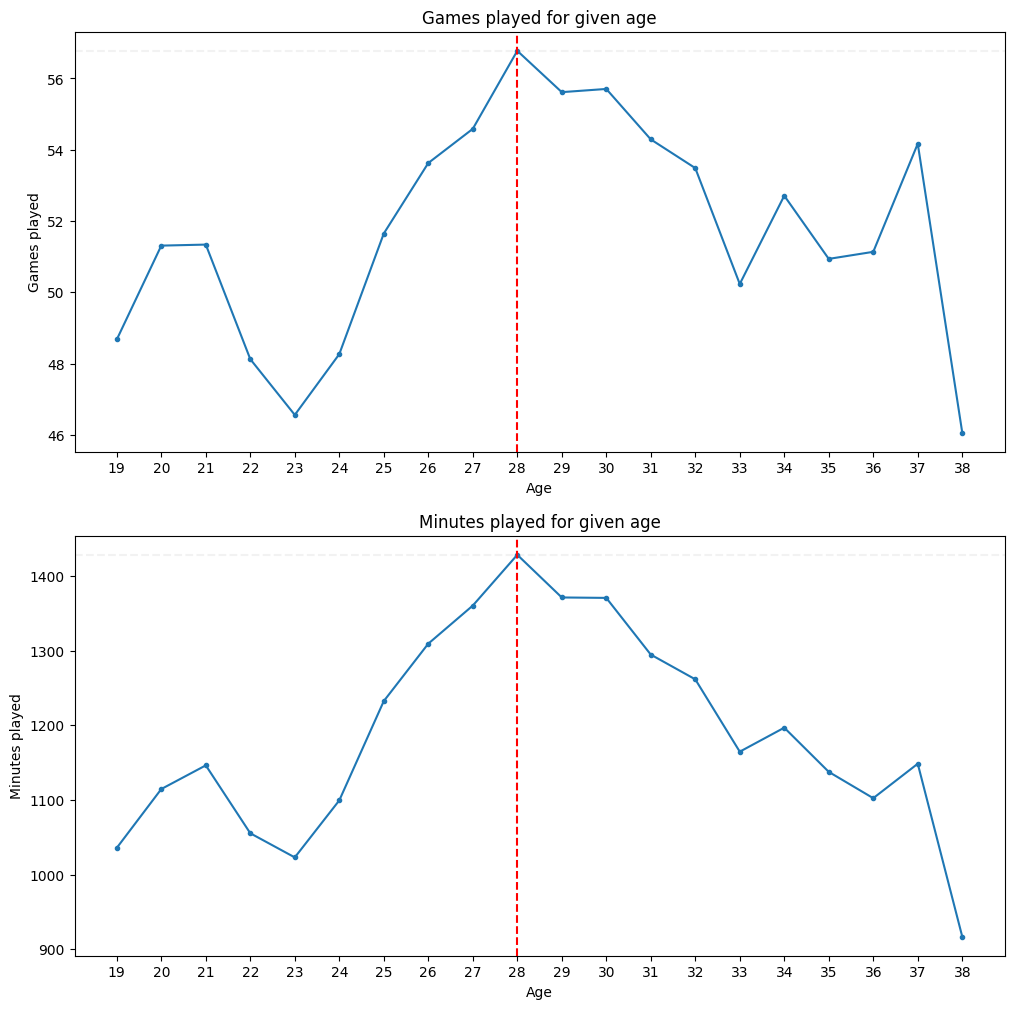

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,12))


total_games_to_age = pd.pivot_table(all_seasons_totals, values='GP', index='Player', columns='Age')
total_games_to_age = get_normalized_dataframe(total_games_to_age)
avrg_total_games_to_age = total_games_to_age.mean()
ax[0].plot(avrg_total_games_to_age.index, avrg_total_games_to_age.values, label='Average games played in a season',  marker='.')
ax[0].set_title('Games played for given age')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Games played')
ax[0].set_xticks(avrg_total_games_to_age.index)
ax[0].axvline(avrg_total_games_to_age.idxmax(), color='r', linestyle='--')
ax[0].axhline(avrg_total_games_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.1)

total_minutes_to_age = pd.pivot_table(all_seasons_totals, values='MIN', index='Player', columns='Age')
total_minutes_to_age = get_normalized_dataframe(total_minutes_to_age)
avrg_total_minutes_to_age = total_minutes_to_age.mean()
ax[1].plot(avrg_total_minutes_to_age.index, avrg_total_minutes_to_age.values, label='Average minutes played in a season',  marker='.')
ax[1].set_title('Minutes played for given age')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Minutes played')
ax[1].set_xticks(avrg_total_minutes_to_age.index)
ax[1].axvline(avrg_total_minutes_to_age.idxmax(), color='r', linestyle='--')
ax[1].axhline(avrg_total_minutes_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.1)


plt.show()

Na wykresie powyżej widać, że średnia liczba meczy i minut na sezon rzeczywiście rośnie od 23 roku życia i zaczyna spadać po 28 roku życia, w którym następuje szczyt fizycznych możliwości zawodnika.

Można również zaobserwować, że statystyki rosną od 19 do 21 roku życia, po czym maleją do 23 roku życia. Tę zależność można zaobserwować zarówno dla liczy meczy i liczby minut na sezon. Prawdopodobnie jest to spowodowane faktem, że najmłodsi zawodnicy NBA (19-21 lat) to gwiazdy amerykańskich uczelni, które grają w większości meczy, choć nieco mniej niż zaprawieni zawodnicy (okres przystosowywania do fizycznych wyzwań NBA). Dla wieków 21-23 statystyki maleją, czego powodem może być przybywanie do NBA młodszych graczy, którzy nie grają tak dobrze jak gwiazdy wzięte do ligi w wieku 19 lat. Obniżony średni poziom gry skutkuje obniżeniem średniej liczby meczy i minut w sezonie. Innym powodem mogłyby być urazy młodych zawodników, którzy będąc nieprzystosowani do fizycznej gry w NBA po grze na poziomie uczelnianym, mogliby nabawić się urazów.    

Inną obserwacją jest fakt, że średnia liczba minut na sezon jest dużo podatniejsza na starzenie - od 28 do 37 roku życia maleje niemal liniowo. Tego samego nie można powiedzieć o liczbie meczy, co nie powinno być dużym zaskoczeniem - starszy zawodnik może wejść na boisko na ledwie parę minut (np. z szacunku, wymogów kontraktowych), a mecz wciąż zostanie dodany do tej statystyki. Tę zależność potwierdza poniższy wykres, ukazujący regresję dla wieku i średniej liczby minut rozgrywanych na mecz.

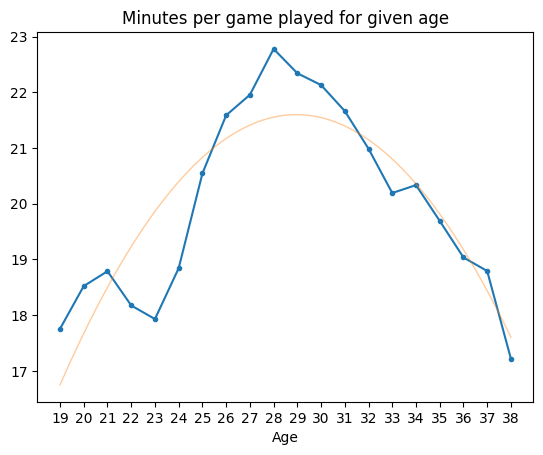

In [15]:
fig, ax = plt.subplots()

minutes_per_game_to_age = pd.pivot_table(all_seasons_per_game, values='MPG', index='Player', columns='Age')
minutes_per_game_to_age = get_normalized_dataframe(minutes_per_game_to_age)
avrg_minutes_per_game_to_age = minutes_per_game_to_age.mean()
ax.plot(avrg_minutes_per_game_to_age.index, avrg_minutes_per_game_to_age.values, label='Minutes per game', marker='.')
ax.set_title('Minutes per game played for given age')
ax.set_xlabel('Age')

model_lin = LinearRegression()
X = avrg_minutes_per_game_to_age.index.values
gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
model_lin.fit(gen_features.fit_transform(X.reshape(-1,1)), avrg_minutes_per_game_to_age.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(gen_features.fit_transform(X_test.reshape(-1,1)))
ax.plot(X_test, Y_pred, linewidth=1, alpha=0.4)

plt.xticks(avrg_minutes_per_game_to_age.index)
plt.show()

Widać wyraźnie, że średnia liczba rozgrywanych minut na mecz wzrasta do 28 roku życia, a następnie maleje. Wykres jest dość "gładki" od 23 do 28 roku życia, gdy rośnie zarówno liczba meczy  i liczba minut w sezonie. Po prawej stronie wykres jest nieco mniej wyrównany, czego powodem jest niejednostajnie malejąca liczba rozgrywanych meczy w sezonie, omówiona wcześniej.

Aby zależność była jeszcze bardziej oczywista, na wykresie na poniższym wykresie przedstawiono średnie zmiany w liczbie rozgrywanych minut w stosunku do statystyk z poprzedniego roku (innymi słowy, jeśli f(x) to liczba minut na mecz w wieku x lat, to przyrost jest dany wzorem g(x) = f(x) / f(x-1) ). Następnie dla każdego wieku obliczono średnią zmianę liczby rozgrywanych minut. Na koniec od przyrostów odjęto 1, aby spadki (wartości stosunkowe mniejsze od 1) były wyrażane przez liczbę ujemną.

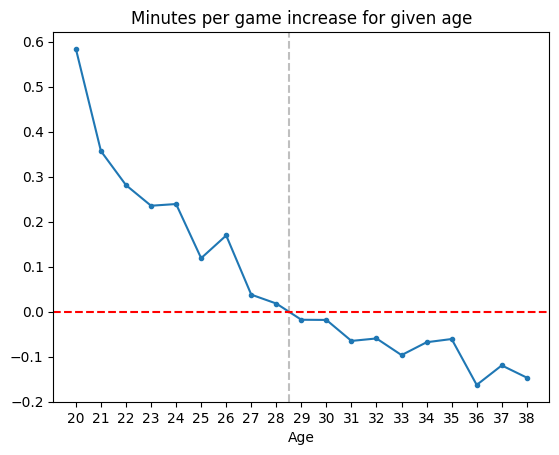

In [16]:
fig, ax = plt.subplots()

minutes_per_game_to_age = pd.pivot_table(all_seasons_per_game, values='MPG', index='Player', columns='Age')
minutes_per_game_to_age = get_normalized_dataframe(minutes_per_game_to_age)
avrg_minutes_per_game_to_age_increase = minutes_per_game_to_age.iloc[:, 1:].div(minutes_per_game_to_age.shift(axis=1).iloc[:, 1:])
avrg_minutes_per_game_to_age_increase = avrg_minutes_per_game_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1
ax.plot(avrg_minutes_per_game_to_age_increase.index, avrg_minutes_per_game_to_age_increase.values, label='Minutes per game increase', marker='.')
ax.set_title('Minutes per game increase for given age')
ax.set_xlabel('Age')
ax.axvline(28.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0, color='red', linestyle='--', label='zero', alpha=1)
plt.xticks(avrg_minutes_per_game_to_age_increase.index)
plt.show()

Ponownie widać, że do około 28 roku życia średnia liczba rozgrywanych minut na mecz rośnie (wartości większe od zera), jednak tempo tego przyrostu maleje (wartości zbliżają się do zera). Natomiast średnia zmiana po osiągnięciu 29 jest zawsze ujemna, co oznacza, że przeciętny zawodnik z roku na rok rozgrywa coraz mniej minut na mecz. Także na tym wykresie można zaobserwować wzrost po 33 roku życia (próba wyjaśnienia pojawi się później), jednak tu interpretacja jest oczywista - rozpatrując wszystkich zawodników w danym wieku średnia liczba minut w sezonie zachowuje się czasem niejednoznacznie, ale gdy rozpatrywani są indywidualni zawodnicy, to po 29 roku życia rozgrywają oni z sezonu na sezon coraz mniej minut.

    Zależność liczby punktów/zbiórek/asyst od wieku

In [18]:
average_points_to_age = pd.pivot_table(all_seasons_per_game, values='PPG', index='Player', columns='Age')
average_points_to_age = get_normalized_dataframe(average_points_to_age).mean()
average_rebounds_to_age = pd.pivot_table(all_seasons_per_game, values='RPG', index='Player', columns='Age')
average_rebounds_to_age = get_normalized_dataframe(average_rebounds_to_age).mean()
average_assists_to_age = pd.pivot_table(all_seasons_per_game, values='APG', index='Player', columns='Age')
average_assists_to_age = get_normalized_dataframe(average_assists_to_age).mean()

Będąc na parkiecie, koszykarz może wspomagać swój zespół w kilku aspektach, z których najważniejsze to: punkty, zbiórki i asysty. Mimo że różni koszykarze specjalizują się w innych aspektach gry, w XXI wieku od niemal każdego zawodnika oczekuje się, że będzie zdobywał punkty. Innymi słowy, nie każda statystyka jest sobie równa. Pokazuje to poniższy wykres.

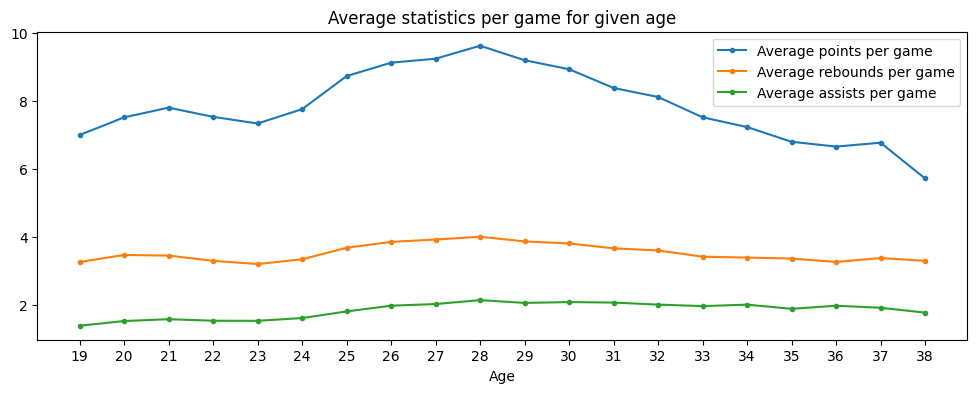

In [19]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(average_points_to_age.index, average_points_to_age.values, label='Average points per game',  marker='.')
ax.plot(average_rebounds_to_age.index, average_rebounds_to_age.values, label='Average rebounds per game',  marker='.')
ax.plot(average_assists_to_age.index, average_assists_to_age.values, label='Average assists per game',  marker='.')
ax.set_title('Average statistics per game for given age')
ax.set_xlabel('Age')
ax.set_xticks(average_points_to_age.index)

plt.legend()
plt.show()

Bez względu na wiek, średnia liczba punktów na mecz zawodników jest ponad dwa razy większa niż liczba zbiórek na mecz, która jest około dwa razy większa od liczby asyst. Punkty nie powinny być zdziwieniem, ponieważ ostatecznie wygrywa drużyna, która zdobędzie ich więcej, stąd też zawodnicy priorytetyzują zdobywanie punktów. Na drugim miejscu umiejscowiły się zbiórki, które również odgrywają w grze znaczącą rolę - zawodnicy próbują złapać piłkę z powietrza, albo żeby kontynuować atak, albo w celu przejścia z obrony do ataku. Głównie w tym celu każda drużyna koszykarska ma w zespole centra, czyli najwyższego zawodnika, którego głównym zadaniem jest zbieranie piłek z powietrza. Na trzecim miejscu plasują się asysty - dogrywanie piłek do niekrytych partnerów ułatwia zdobywanie punktów, ale nowoczesne NBA w dużej mierze opiera się na indywidualnych akcjach zawodników, którzy sami mogą okiwać obrońcę i wykonać rzut. W porównaniu do np. piłki nożnej dużo łatwiej jest też przebiec przez całe boisko bez podawania piłki, stąd sumaryczna liczba asyst jest mniejsza. 

Ze względu na skalę, na powyższym wykresie nie widać, w jakim wieku przeciętny zawodnik osiąga największą liczbę punktów, zbiórek i asyst. Te wartości zostały przedstawione poniżej.

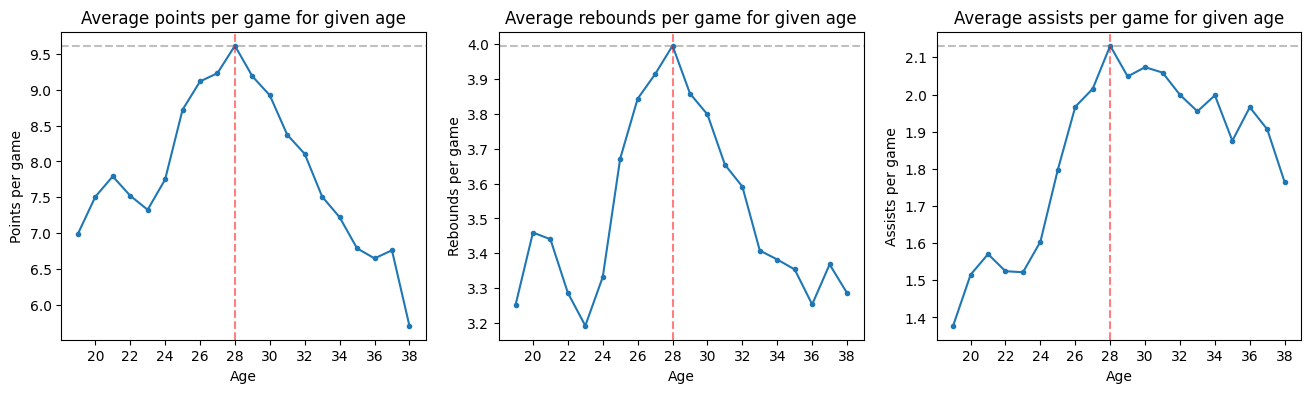

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

every_second_year = average_points_to_age.index.to_list()[1::2]

ax[0].plot(average_points_to_age.index, average_points_to_age.values,  marker='.')
ax[0].axvline(average_points_to_age.idxmax(), color='r', linestyle='--', alpha=0.5)
ax[0].axhline(average_points_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.5)
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Points per game')
ax[0].set_xticks(every_second_year)
ax[0].set_title('Average points per game for given age')

ax[1].plot(average_rebounds_to_age.index, average_rebounds_to_age.values,  marker='.')
ax[1].axvline(average_rebounds_to_age.idxmax(), color='r', linestyle='--', alpha=0.5)
ax[1].axhline(average_rebounds_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.5)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Rebounds per game')
ax[1].set_xticks(every_second_year)
ax[1].set_title('Average rebounds per game for given age')

ax[2].plot(average_assists_to_age.index, average_assists_to_age.values, marker='.')
ax[2].axvline(average_assists_to_age.idxmax(), color='r', linestyle='--', alpha=0.5)
ax[2].axhline(average_assists_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.5)
ax[2].set_xlabel('Age')
ax[2].set_ylabel('Assists per game')
ax[2].set_xticks(every_second_year)
ax[2].set_title('Average assists per game for given age')

plt.show()

Ponownie wiek 28 lat okazuje się być wiekiem, w którym przeciętny zawodnik osiąga najwyższe osiągi w punktach, zbiórkach i asystach na mecz. Biorąc pod uwagę wcześniejsze wykresy można jednoznacznie stwierdzić, że w wieku 28 lat przeciętny koszykarz NBA rozgrywa najlepszy sezon, z największą liczbą meczy, punktów, zbiórek i asyst w sezonie.

Można też sprawdzić jak zmieniają się te statystyki z roku na rok, a więc w jakim stopniu wiek wpływa na osiągane wyniki. 

In [21]:
total_points_to_age = pd.pivot_table(all_seasons_totals, values='PTS', index='Player', columns='Age')
total_points_to_age = get_normalized_dataframe(total_points_to_age).mean()
total_rebounds_to_age = pd.pivot_table(all_seasons_totals, values='REB', index='Player', columns='Age')
total_rebounds_to_age = get_normalized_dataframe(total_rebounds_to_age).mean()
total_assists_to_age = pd.pivot_table(all_seasons_totals, values='AST', index='Player', columns='Age')
total_assists_to_age = get_normalized_dataframe(total_assists_to_age).mean()

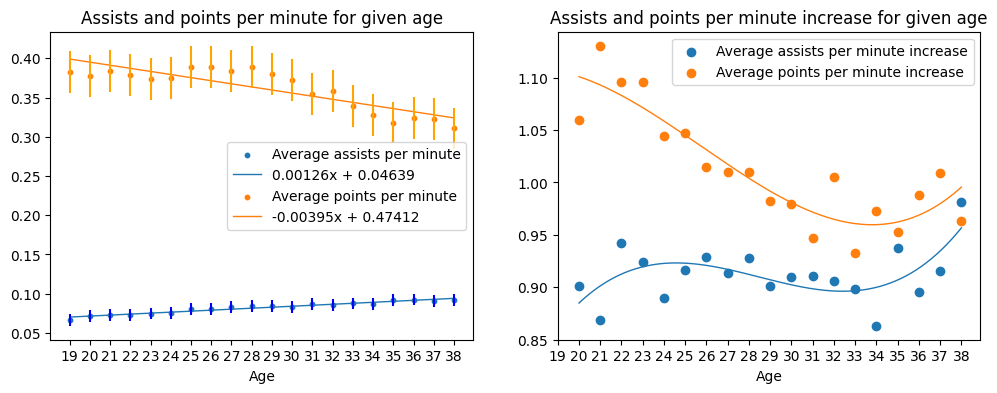

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

assists_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='AST', index='Player', columns='Age')
assists_per_minute_to_age = get_normalized_dataframe(assists_per_minute_to_age)
avrg_assists_per_minute_to_age = assists_per_minute_to_age.mean()
ax[0].scatter(avrg_assists_per_minute_to_age.index, avrg_assists_per_minute_to_age.values, s=10, label='Average assists per minute')
model_lin = LinearRegression()
X = avrg_assists_per_minute_to_age.index.values
model_lin.fit(X.reshape(-1,1), avrg_assists_per_minute_to_age.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[0].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")
errors = np.std(avrg_assists_per_minute_to_age.values, axis=0)
ax[0].errorbar(avrg_assists_per_minute_to_age.index, avrg_assists_per_minute_to_age.values, yerr=errors, fmt=' ', color='blue')

points_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='PTS', index='Player', columns='Age')
points_per_minute_to_age = get_normalized_dataframe(points_per_minute_to_age)
avrg_points_per_minute_to_age = points_per_minute_to_age.mean()
ax[0].scatter(avrg_points_per_minute_to_age.index, avrg_points_per_minute_to_age.values, s=10, label='Average points per minute')
model_lin = LinearRegression()
X = avrg_points_per_minute_to_age.index.values
model_lin.fit(X.reshape(-1,1), avrg_points_per_minute_to_age.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[0].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")
errors = np.std(avrg_points_per_minute_to_age.values, axis=0)
ax[0].errorbar(avrg_points_per_minute_to_age.index, avrg_points_per_minute_to_age.values, yerr=errors, fmt=' ', color='orange')


ax[0].set_title('Assists and points per minute for given age')
ax[0].set_xlabel('Age')
ax[0].set_xticks(avrg_assists_per_minute_to_age.index)
ax[0].legend()


avrg_assists_per_minute_increase = assists_per_minute_to_age.iloc[:, 1:].div(assists_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_assists_per_minute_increase = avrg_assists_per_minute_increase.replace([np.inf, -np.inf], np.nan).mean()
ax[1].scatter(avrg_assists_per_minute_increase.index, avrg_assists_per_minute_increase.values, label='Average assists per minute increase')
model_lin = LinearRegression()
X = avrg_assists_per_minute_increase.index.values
gen_features = PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)
model_lin.fit(gen_features.fit_transform(X.reshape(-1,1)), avrg_assists_per_minute_increase.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(gen_features.fit_transform(X_test.reshape(-1,1)))
ax[1].plot(X_test, Y_pred, linewidth=1)

avrg_points_per_minute_increase = points_per_minute_to_age.iloc[:, 1:].div(points_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_points_per_minute_increase = avrg_points_per_minute_increase.replace([np.inf, -np.inf], np.nan).mean()
ax[1].scatter(avrg_points_per_minute_increase.index, avrg_points_per_minute_increase.values, label='Average points per minute increase')
model_lin = LinearRegression()
X = avrg_points_per_minute_increase.index.values
gen_features = PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)
model_lin.fit(gen_features.fit_transform(X.reshape(-1,1)), avrg_points_per_minute_increase.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(gen_features.fit_transform(X_test.reshape(-1,1)))
ax[1].plot(X_test, Y_pred, linewidth=1)

ax[1].set_title('Assists and points per minute increase for given age')
ax[1].set_xlabel('Age')
ax[1].set_xticks(avrg_assists_per_minute_to_age.index)
ax[1].legend()

plt.show()

Lewy wykres pokazuje, że podczas gdy w perspektywie całej kariery średnio zawodnik zdobywa coraz mniej punktów na minutę, liczba asyst nie tylko nie maleje, ale nawet rośnie. Można więc stwierdzić, że starzenie nie ma tak destruktywnego wpływu na asystowanie jak na zdobywanie punktów. Mogłoby to również sugerować, że z racji coraz gorszych możliwości zdobywania punktów, gracz próbuje wspierać drużynę przez asystowanie.

Z kolei prawy wykres pokazuje średnie zmiany liczby punktów asyst zawodników w porównaniu do poprzedniego roku. Ponownie widać, że przyrost liczby punktów na minutę maleje dość gwałtownie, podczas gdy przyrost liczby asyst na minutę prawie niezależny od wieku (choć mniejszy od 1). Wskazuje to jednoznacznie na fakt, że asysty są znacznie mniej zależne od wieku zawodnika niż zdobywane punkty.

Kolejna hipoteza do sprawdzenia stwierdza, że wiek wpływa na więcej niż tylko liczba punktów - zmianie może ulegać także procentowa skuteczność rzutów (zawodnik doskonali formę/starzenie negatywnie wpływa na formę) oraz sumaryczna liczba prób zdobycia punktów (więcej prób aby mimo starzenia utrzymać stałą liczbę punktów/mniej prób spowodowane malejącą skutecznością rzutów).

    Zależność liczby prób rzutów od wieku

Rzuty można podzielić na rzuty osobiste i rzuty z gry (field goals), które dalej można podzielić na rzuty za dwa punkty i rzuty za trzy punkty.

Rzuty za dwa punkty są oddawane z mniejszej odległości, teoretycznie więc łatwiej jest trafić. Z drugiej strony im bliżej kosza stoi zawodnik, tym aktywniej będzie on kryty przez obrońcę z drużyny przeciwnej.

Rzuty za trzy punkty są oddawane zza linii trzech punktów - odległość jest większa, więc trudniej jest trafić. Tym samym zawodnicy mają większą swobodę oddawania rzutów.

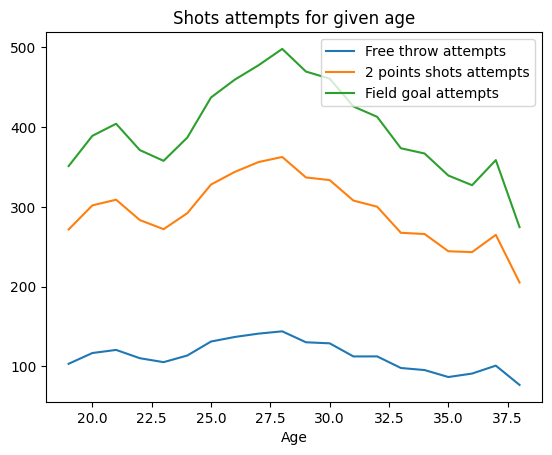

In [67]:
fig, ax = plt.subplots()

_total_minutes_played_to_age = pd.pivot_table(all_seasons_totals, values='MIN', index='Player', columns='Age')
total_3pts_attempts_to_age = pd.pivot_table(all_seasons_totals, values='3PA', index='Player', columns='Age')

total_field_goals_attempts_to_age = pd.pivot_table(all_seasons_totals, values='FGA', index='Player', columns='Age')
total_field_goals_attempts_to_age_average = get_normalized_dataframe(total_field_goals_attempts_to_age).mean()
_2pts_attempts_per_minute_to_age = (total_field_goals_attempts_to_age - total_3pts_attempts_to_age)
_2pts_attempts_per_minute_to_age = get_normalized_dataframe(_2pts_attempts_per_minute_to_age).mean()
#_2pts_attempts_per_minute_to_age_increase = _2pts_attempts_per_minute_to_age.iloc[:, 1:].div(_2pts_attempts_per_minute_to_age.shift(axis=1).iloc[:, 1:])
#_2pts_attempts_per_minute_to_age_increase = _2pts_attempts_per_minute_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1

_free_throw_attempts_per_minute_to_age = pd.pivot_table(all_seasons_totals, values='FTA', index='Player', columns='Age')
_free_throw_attempts_per_minute_to_age = get_normalized_dataframe(_free_throw_attempts_per_minute_to_age).mean()
#_free_throw_attempts_per_minute_to_age_increase = _free_throw_attempts_per_minute_to_age.iloc[:, 1:].div(_free_throw_attempts_per_minute_to_age.shift(axis=1).iloc[:, 1:])
#_free_throw_attempts_per_minute_to_age_increase = _free_throw_attempts_per_minute_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1

ax.plot(_free_throw_attempts_per_minute_to_age.index, _free_throw_attempts_per_minute_to_age.values, label='Free throw attempts')
ax.plot(_2pts_attempts_per_minute_to_age.index, _2pts_attempts_per_minute_to_age.values, label='2 points shots attempts')
ax.plot(total_field_goals_attempts_to_age_average.index, total_field_goals_attempts_to_age_average.values, label='Field goal attempts')

ax.set_title('Shots attempts for given age')
ax.set_xlabel('Age')
#ax.axvline(28.5, color='gray', linestyle='--', alpha=0.5)
#ax.axhline(0, color='red', linestyle='--', label='zero', alpha=1)
#plt.xticks(_3pts_attempts_to_age_increase.index)
plt.legend()
plt.show()

Widać, że powyższy wykres prób rzutów przypomina zależności punktów od wieku - nie powinno to dziwić, bo im więcej zawodnik zdobywa punktów, tym więcej musiał wykonać rzutów. Wszystkie liczby prób maleją też od ok. 28 roku życia. Co do liczby rzutów osobistych, są one bezpośrednio skorelowane z liczbą rzutów z gry. Rzuty osobiste są oddawane, gdy zawodnik został sfaulowany podczas wykonywania rzutu. Można się więc spodziewać, że na liczbę wykonywanych rzutów osobistych wpływa czas przebywania zawodnika na boisku oraz miejsce tego przebywania. Wcześniej okazało się, że starzejący się zawodnicy coraz bardziej preferują rzuty za 3 punkty w porównaniu do rzutów za dwa punkty. Za linią trzech punktów krycie jest znacznie słabsze, a tym samym zawodnik dużo rzadziej jest faulowany.

Na wykresie widać, że liczba oddawanych rzutów osobistych rzeczywiście jest skorelowana z liczbą oddawanych rzutów z gry - liczby rosną do około 21 roku życia, maleją do 22 po czym rosną aż do około 28 życia, po czym maleją niemal do końca kariery. Oczywiście wykres liczby rzutów osobistych jest spłaszczony w porównaniu do wykresów rzutów z gry i za 2 punkty, gdyż rzuty osobiste wykonywane są tylko po faulach na zawodnikach wykonujących rzut z gry.

Poprzednią hipotezę co do liczby rzutów można poszerzyć: z upływem lat zawodnicy będą oddawać coraz mniej rzutów za dwa punkty (większa rywalizacja pod koszem, fizyczna gra), a więcej rzutów za trzy punkty, które są więcej punktowane, a przy których odczuwa się słabsze krycie. Zależność między średnim wzrostem liczby rzutów za 2 i za 3 punkty przedstawia poniższy wykres.

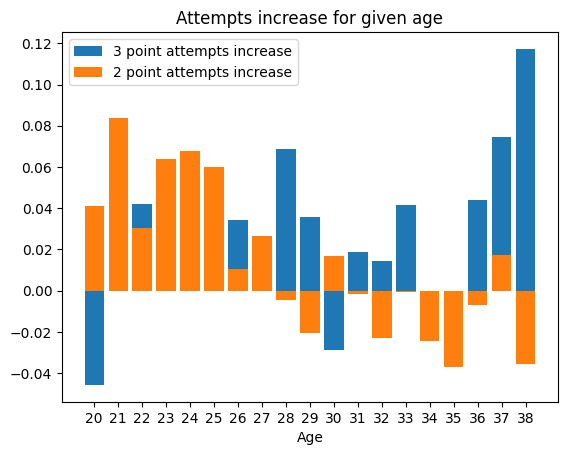

In [26]:
fig, ax = plt.subplots()

_3pts_attempts_to_age = pd.pivot_table(all_seasons_per_minute, values='3PA', index='Player', columns='Age')
_3pts_attempts_to_age = get_normalized_dataframe(_3pts_attempts_to_age)
_3pts_attempts_to_age_increase = _3pts_attempts_to_age.iloc[:, 1:].div(_3pts_attempts_to_age.shift(axis=1).iloc[:, 1:])
_3pts_attempts_to_age_increase = _3pts_attempts_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1

_field_goals_attempts_to_age = pd.pivot_table(all_seasons_per_minute, values='FGA', index='Player', columns='Age')
_field_goals_attempts_to_age = get_normalized_dataframe(_field_goals_attempts_to_age)
_2pts_attempts_to_age = _field_goals_attempts_to_age - _3pts_attempts_to_age
_2pts_attempts_to_age_increase = _2pts_attempts_to_age.iloc[:, 1:].div(_2pts_attempts_to_age.shift(axis=1).iloc[:, 1:])
_2pts_attempts_to_age_increase = _2pts_attempts_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1

ax.bar(_3pts_attempts_to_age_increase.index, _3pts_attempts_to_age_increase.values, label='3 point attempts increase')
ax.bar(_2pts_attempts_to_age_increase.index, _2pts_attempts_to_age_increase.values, label='2 point attempts increase')

ax.set_title('Attempts increase for given age')
ax.set_xlabel('Age')
plt.xticks(_3pts_attempts_to_age_increase.index)
plt.legend()
plt.show()

Wyraźnie widać, że liczba rzutów za 2 punkty spada sezonu na sezon po osiągnięciu około 30 roku życia. Zupełnie odwrotnie jest z rzutami za 3 punkty - średnio po 30 roku życia w żadnym sezonie liczba tych rzutów nie maleje. Co więcej, od 36 roku życia obserwuje się gwałtowny wzrost. To sugeruje, że starzejący się zawodnicy rzeczywiście coraz bardziej preferują oddawanie rzutów z mniej strzeżonych pozycji, za które mogą zdobyć więcej punktów, niż za rzuty spod kosza. Nie oznacza to oczywiście, że oddają więcej rzutów za 3 punkty niż za 2 punkty - oddają natomiast stosunkowo coraz więcej rzutów za trzy punkty i coraz mniej za dwa, niż w poprzednich latach kariery.

    Zależność skuteczności rzutów od wieku

LinearRegression()


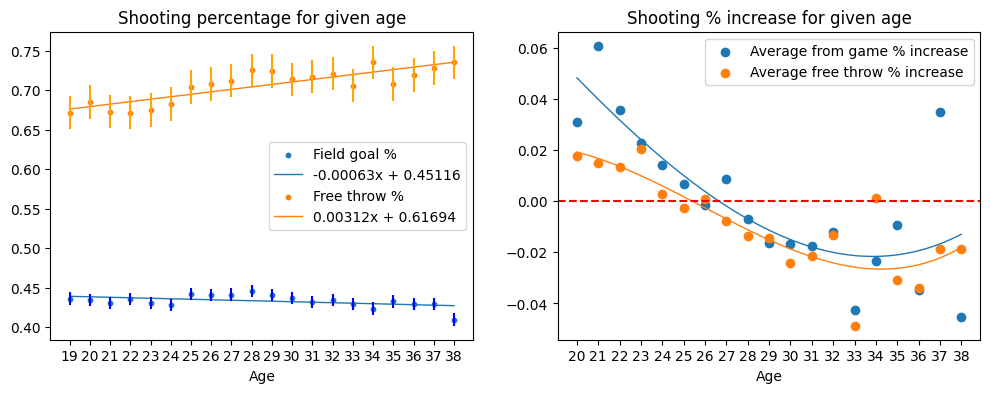

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

field_goal_percentage_to_age = pd.pivot_table(all_seasons_totals, values='FG%', index='Player', columns='Age')
field_goal_percentage_to_age = get_normalized_dataframe(field_goal_percentage_to_age)
average_field_goal_percentage_to_age = field_goal_percentage_to_age.mean()

errors = np.std(average_field_goal_percentage_to_age.values, axis=0)
ax[0].scatter(average_field_goal_percentage_to_age.index, average_field_goal_percentage_to_age.values, s=10, label='Field goal %')
model_lin = LinearRegression()
X = average_field_goal_percentage_to_age.index.values
model_lin.fit(X.reshape(-1,1), average_field_goal_percentage_to_age.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[0].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")
ax[0].errorbar(average_field_goal_percentage_to_age.index, average_field_goal_percentage_to_age.values, yerr=errors, fmt=' ', color='blue')


free_throw_percentage_to_age = pd.pivot_table(all_seasons_per_minute, values='FT%', index='Player', columns='Age')
free_throw_percentage_to_age = get_normalized_dataframe(free_throw_percentage_to_age)
average_free_throw_percentage_to_age = free_throw_percentage_to_age.mean()

errors = np.std(average_free_throw_percentage_to_age.values, axis=0)
ax[0].scatter(average_free_throw_percentage_to_age.index, average_free_throw_percentage_to_age.values, s=10, label='Free throw %')
model_lin = LinearRegression()
X = average_free_throw_percentage_to_age.index.values
model_lin.fit(X.reshape(-1,1), average_free_throw_percentage_to_age.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[0].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")
ax[0].errorbar(average_free_throw_percentage_to_age.index, average_free_throw_percentage_to_age.values, yerr=errors, fmt=' ', color='orange')

ax[0].set_title('Shooting percentage for given age')
ax[0].set_xlabel('Age')
ax[0].set_xticks(average_free_throw_percentage_to_age.index)
ax[0].legend()


field_goal_percentage_to_age_increase = field_goal_percentage_to_age.iloc[:, 1:].div(field_goal_percentage_to_age.shift(axis=1).iloc[:, 1:])
avrg_field_goal_percentage_to_age_increase = field_goal_percentage_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1
ax[1].scatter(avrg_field_goal_percentage_to_age_increase.index, avrg_field_goal_percentage_to_age_increase.values, label=r"Average from game % increase")
model_lin = LinearRegression()
X = avrg_field_goal_percentage_to_age_increase.index.values
gen_features = PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)
model_lin.fit(gen_features.fit_transform(X.reshape(-1,1)), avrg_field_goal_percentage_to_age_increase.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(gen_features.fit_transform(X_test.reshape(-1,1)))
ax[1].plot(X_test, Y_pred, linewidth=1)

avrg_free_throw_percentage_to_age_increase = free_throw_percentage_to_age.iloc[:, 1:].div(free_throw_percentage_to_age.shift(axis=1).iloc[:, 1:])
avrg_points_per_minute_increase = avrg_free_throw_percentage_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1
ax[1].scatter(avrg_points_per_minute_increase.index, avrg_points_per_minute_increase.values, label=r'Average free throw % increase')
model_lin = LinearRegression()
X = avrg_points_per_minute_increase.index.values
gen_features = PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)
model_lin.fit(gen_features.fit_transform(X.reshape(-1,1)), avrg_points_per_minute_increase.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(gen_features.fit_transform(X_test.reshape(-1,1)))
ax[1].plot(X_test, Y_pred, linewidth=1)
print(model_lin)
ax[1].axhline(0, color='red', linestyle='--', alpha=1)
ax[1].set_title(f'Shooting % increase for given age')
ax[1].set_xlabel('Age')
ax[1].set_xticks(avrg_points_per_minute_increase.index)
ax[1].legend(loc='upper right')

plt.show()

Na lewym wykresie wyraźnie widać, że średnia skuteczność rzutów osobistych w perspektywie 18-letniej kariery jest rosnąca. Dla rzutów z gry przeciwnie - skuteczność w perspektywie kariery maleje w stałym tempie, stąd mniejsze odchylenie standardowe. Jest to najprawdopodobniej spowodowane faktem, że na rzut osobisty ma wpływ tylko i wyłącznie gracz oddający rzut - nikt nie zasłania kosza ani nie może przeszkadzać, stąd pole do doskonalenia rzutów osobistych jest dużo większe niż dla rzutów z gry. Można też zauważyć, że do 24 roku życia skuteczność jest poniżej średniej skuteczności w karierze, następnie do około 30 roku życia skuteczność jest większa niż średnia skuteczność w karierze, by na koniec ponownie spaść poniżej średniej.

Na prawym wykresie widać przeciętny wzrost skuteczności z roku na rok dla zawodników w różnym wieku. Skuteczność rzutów rzeczywiście rośnie do około 25 roku życia. Widać również, że zmiany skuteczności rzutów z pola zmieniają się gwałtowniej niż zmiany skuteczności rzutów osobistych - ponownie, powodem jest prawdopodobnie to, że na skuteczność rzutów z pola wpływa nie tylko forma rzutu, ale także skuteczność obrony przeciwnika, wysokość wyskoku, oszacowanie zmiennej odległości od kosza itp. Interesujący może być natomiast fakt spłaszczenia krzywej spadkowej w ostatnich latach gry. Jest to prawdopodobnie spowodowane faktem, że większość zawodników grających w tym wieku to gwiazdy NBA, które mają na koncie liczne osiągnięcia i mimo wieku są w bardzo wysokiej formie. Procentowy udział jakościowych zawodników w starszym wieku jest dużo wyższy niż w latach szczytu fizycznych możliwości, stąd średnia skuteczność rzutów maleje w stopniu dużo mniejszym niż u przeciętnych zawodników lub nawet może rosnąć.

    W jakim momencie gracze rozgrywają ostatni sezon w NBA?

Ostatnie pytanie które zostanie zadane w kwestii wieku graczy to w jakim wieku zawodnicy rozgrywają przeciętnie swój ostatni sezon w NBA.

Oczywiście nie każdy ostatni sezon w NBA oznacza zakończenie kariery ze względu na słabe statystyki. Zawodnik może zmienić ligę koszykarską lub zakończyć grę z powodów osobistych/kontuzji. Z dużą pewnością można jednak stwierdzić, że przeważająca większość graczy po 28 roku życia (szczyt kariery) rozgrywa w NBA ostatni sezon, ponieważ kluby nie potrzebują już ich wkładu w grę.

Rozważani będą tylko zawodnicy w wieku powyżej 28 lat, którzy nie grali ani w sezonie 2020-2021, ani w sezonie 2021-2022 (ostatnie dwa analizowane sezony) - eliminujemy tym mylące statystyki zawodników, którzy wciąż mogą grać w obecnym sezonie 2022-2023 (nie zakończyli jeszcze kariery) lub którzy z powodu kontuzji musieli opuścić sezon 2021-2022 a grali w poprzednim sezonie. Dane nie zostały znormalizowane w celu uwzględnienia także starszych koszykarzy. Łączna liczba kwalifikujących się zawodników to 686.

In [28]:
season_2022 = dataframes['totals', 2022].reset_index()
season_2022_players = season_2022['Player']
season_2021 = dataframes['totals', 2021].reset_index()
season_2021_players = season_2021['Player']
season_2020 = dataframes['totals', 2020].reset_index()
season_2020_players = season_2020['Player']

merged = all_seasons_totals.merge(season_2022_players, on='Player', how='left', indicator=True)
not_active_players_totals = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')
merged = not_active_players_totals.merge(season_2021_players, on='Player', how='left', indicator=True)
not_active_players_totals = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')
merged = not_active_players_totals.merge(season_2020_players, on='Player', how='left', indicator=True)
not_active_players_totals = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')

max_ages = not_active_players_totals.groupby('Player')['Age'].transform(max)
last_years = not_active_players_totals[not_active_players_totals['Age'] == max_ages]
last_years = last_years[last_years['Age'] > 28]
display(last_years.sort_values(by="Age"))

,Player,Pos,...,TOV,PF
6110,Travis Outlaw,F,...,26,94
6530,Shawne Williams,F,...,30,135
...,...,...,...,...,...
4200,Dikembe Mutombo,C,...,6,11
3507,Kevin Willis,C,...,2,11


Średnia wieku przy rozgrywaniu ostatniego sezonu:

In [29]:
average_last_year_played = last_years['Age'].mean()
print(average_last_year_played)

33.01749271137026


Okazuje się, że średni wiek zawodników z tej grupy to 33 lata - tym wieku przeciętny zawodnik po 28 roku życia rozgrywa w NBA swój ostatni sezon. Wynik jest o tyle interesujący, że na wykresach przedstawiających średnią liczbę rozgrywanych meczy i minut w sezonie w 33 roku życia odnotowuje się lokalne minimum, a na wykresach dotyczących punktów, zbiórek i asyst obserwuje się gwałtowny spadek średniej. Około 33 roku życia można zauważyć także punkt przegięcia na wykresie obrazującym zmiany skuteczności rzutów osobistych i z gry. Wygląda więc na to, że w tym wieku większość starzejących się zawodników osiąga statystyki skłaniające ich do zakończenia gry w NBA. Po ich odejściu stosunek jakościowych graczy powyżej 33 roku życia zwiększa się, stąd też można zaobserwować w tej grupie wzrost w średniej liczby rozgrywanych meczy i minut na sezon, jak również korzystniejsze statystyki dotyczące asyst i punktów na minutę oraz skuteczności rzutów.

Podobne wnioski można wyciągnąć na podstawie poniższych wykresów, obrazujących średnią liczbę meczy, minut i punktów oraz średnią skuteczność zawodników z tej grupy.

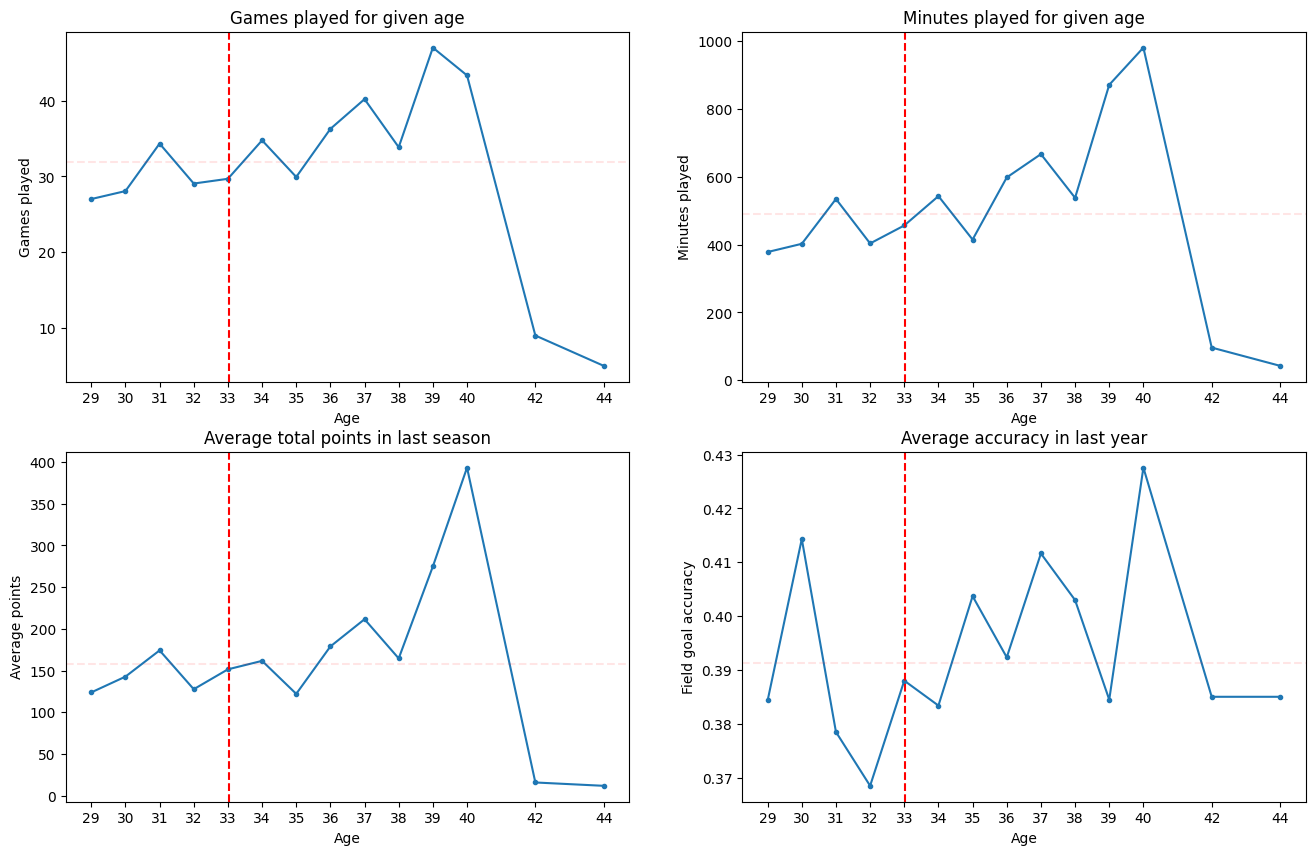

In [30]:
average_games_per_season_in_last_year = last_years['GP'].mean()
average_minutes_per_season_in_last_year = last_years['MIN'].mean()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10))


total_games_to_age = pd.pivot_table(last_years, values='GP', index='Player', columns='Age')
avrg_total_games_to_age = total_games_to_age.mean()
ax[0][0].plot(avrg_total_games_to_age.index, avrg_total_games_to_age.values, label='Average games played in a season',  marker='.')
ax[0][0].set_title('Games played for given age')
ax[0][0].set_xlabel('Age')
ax[0][0].set_ylabel('Games played')
ax[0][0].set_xticks(avrg_total_games_to_age.index)
ax[0][0].axvline(average_last_year_played, color='r', linestyle='--')
ax[0][0].axhline(average_games_per_season_in_last_year, color='red', linestyle='--', alpha=0.1)

total_minutes_to_age = pd.pivot_table(last_years, values='MIN', index='Player', columns='Age')
avrg_total_minutes_to_age = total_minutes_to_age.mean()
ax[0][1].plot(avrg_total_minutes_to_age.index, avrg_total_minutes_to_age.values, label='Average minutes played in a season',  marker='.')
ax[0][1].set_title('Minutes played for given age')
ax[0][1].set_xlabel('Age')
ax[0][1].set_ylabel('Minutes played')
ax[0][1].set_xticks(avrg_total_minutes_to_age.index)
ax[0][1].axvline(average_last_year_played, color='r', linestyle='--')
ax[0][1].axhline(average_minutes_per_season_in_last_year, color='red', linestyle='--', label='max value', alpha=0.1)

average_points_in_last_year = last_years['PTS'].mean()
average_accuracy_in_last_year = last_years['FG%'].mean()

total_points_to_age = pd.pivot_table(last_years, values='PTS', index='Player', columns='Age')
avrg_total_points_to_age = total_points_to_age.mean()
ax[1][0].plot(avrg_total_points_to_age.index, avrg_total_points_to_age.values, label='Average total points in last season',  marker='.')
ax[1][0].set_title('Average total points in last season')
ax[1][0].set_xlabel('Age')
ax[1][0].set_ylabel('Average points')
ax[1][0].set_xticks(avrg_total_points_to_age.index)
ax[1][0].axvline(average_last_year_played, color='r', linestyle='--')
ax[1][0].axhline(average_points_in_last_year, color='red', linestyle='--', alpha=0.1)

accuracy_to_age = pd.pivot_table(last_years, values='FG%', index='Player', columns='Age')
avrg_accuracy_to_age = accuracy_to_age.mean()
ax[1][1].plot(avrg_accuracy_to_age.index, avrg_accuracy_to_age.values, label='Average field goal accuracy in last year',  marker='.')
ax[1][1].set_title('Average accuracy in last year')
ax[1][1].set_xlabel('Age')
ax[1][1].set_ylabel('Field goal accuracy')
ax[1][1].set_xticks(avrg_accuracy_to_age.index)
ax[1][1].axvline(average_last_year_played, color='r', linestyle='--')
ax[1][1].axhline(average_accuracy_in_last_year, color='red', linestyle='--', label='max value', alpha=0.1)


plt.show()

    Zależność gry koszykarzy od wzrostu

Nie ulega wątpliwości, że wzrost zawodnika ma wpływ na styl jego gry. Najprawdopodobniej daje mu także przewagę nad innymi graczami, skoro tak wielu koszykarzy ma ponad dwa metry. Poniżej zostanie dokonana analiza zależności między wzrostem zawodników a ich statystykami.

Rozkład wzrostu zawodników NBA:

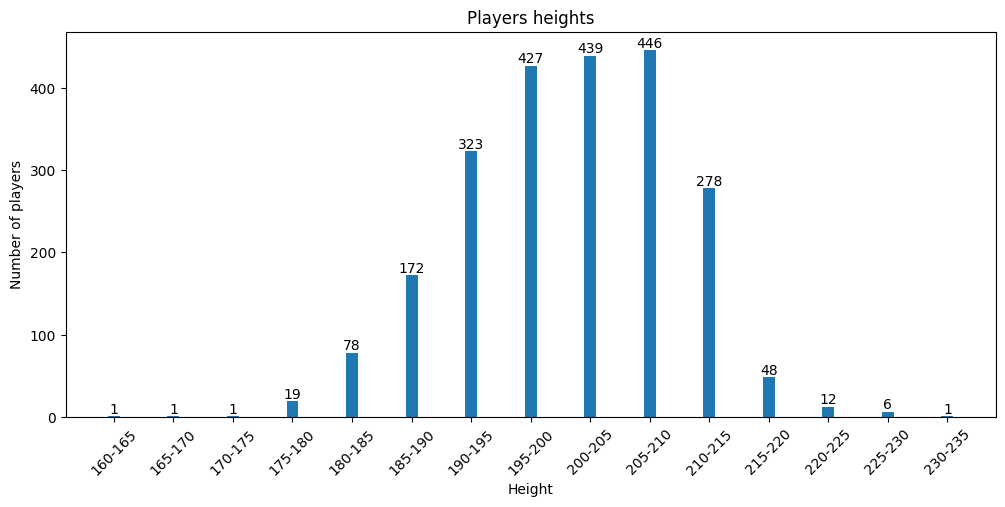

In [34]:
all_players_all_seasons_bios = pd.concat([dataframes["bios", year] for year in years])['HT']
all_nonduplicate_players_bios = all_players_all_seasons_bios.reset_index().drop_duplicates(subset=all_players_all_seasons_bios.index.name, keep="first").set_index("Player")
all_nonduplicate_players_bios = all_nonduplicate_players_bios["HT"]
heights = all_nonduplicate_players_bios.groupby(all_nonduplicate_players_bios.values).size()

range_boundaries = [ht for ht in range(int(heights.index[0]), int(heights.index[-1]+5), 5)]
bins = pd.cut(all_nonduplicate_players_bios.values, bins=range_boundaries, labels=range_boundaries[1:], include_lowest=True)
grouped = all_nonduplicate_players_bios.groupby(bins).size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(12,5))

ax.bar(grouped["index"].values, grouped["count"].values, width=1)
ax.set_title('Players heights')
ax.set_xlabel('Height')
ax.set_ylabel('Number of players')
ax.set_xticks(grouped["index"].values,labels=[f"{ht-5}-{ht}" for ht in grouped["index"].values], rotation=45)

ax.bar_label(ax.containers[0], fmt='%d', label_type='edge')

plt.show()


    Zależność liczby minut od wzrostu

NBA w XXI wieku wygląda zupełnie inaczej niż parę dekad temu. Dzisiejsza dynamika gry jest dużo większa, zawodnicy muszą biegać od swojego kosza do drugiego w pełnej szybkości. W tym aspekcie wzrost nie wydaje się dawać przewagi. Im większy wzrost, tym z reguły większa masa, więc ciało potrzebuje więcej tlenu podczas wysiłku. Można więc wysunąć hipotezę, że średnia liczba minut na mecz wyższych zawodników będzie mniejsza, niż zawodników o niższym wzroście.

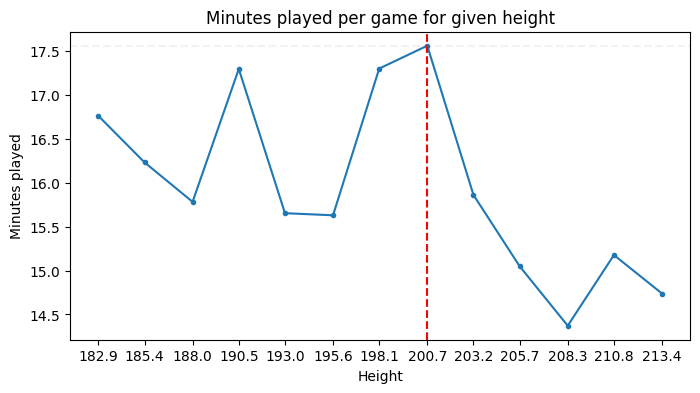

In [35]:
fig, ax = plt.subplots(figsize=(8,4))

average_minutes_to_height = pd.pivot_table(all_seasons_per_game, values='MPG', index='Player', columns='HT')
average_minutes_to_height = get_normalized_dataframe(average_minutes_to_height)
average_minutes_to_height = average_minutes_to_height.mean()
ax.plot(average_minutes_to_height.index, average_minutes_to_height.values, label='Average minutes played in a game',  marker='.')
ax.set_title('Minutes played per game for given height')
ax.set_xlabel('Height')
ax.set_ylabel('Minutes played')
ax.set_xticks(average_minutes_to_height.index)
ax.axvline(average_minutes_to_height.idxmax(), color='r', linestyle='--')
ax.axhline(average_minutes_to_height.max(), color='gray', linestyle='--', label='max value', alpha=0.1)

plt.show()

Powyższy wykres potwierdza te podejrzenia. Zawodnicy powyżej 200 centymetrów rozgrywają coraz mniej minut na mecz, co potwierdzałoby postawioną hipotezę. Niejednoznaczny rozkład dla wzrostów poniżej 200 cm może mięc związek z niejasną jeszcze rolą wzrostu - zawodnicy niżsi mogą rozgrywać mniej minut na mecz nie ze względu na zdolności fizyczne, ale na mniejsze możliwości pomocy drużynie związane z niskim wzrostem.

    Zależność liczby punktów/asyst/zbiórek od wzrostu

Tutaj również nasuwa się oczywista hipoteza: im wyższy jest zawodnik, tym łatwiej będzie mu złapać piłkę z powietrza - odnotuje więc więcej zbiórek. Z reguły najwyżsi koszykarze stoją w pobliżu kosza w celu wykonywania krótkich rzutów po podaniach od kolegów - sami z reguły nie podają, będąc w korzystniejszej pozycji do zdobycia punktów. Można się więc spodziewać, że liczba asyst także będzie skorelowana ze wzrostem. Trudno natomiast określić, jaka będzie zależność między wzrostem a zdobywanymi punktami. Z jednej strony center ma bliżej do kosza, z drugiej - zdobywa jedynie punkty za 2 i jest kryty przez centra drugiej drużyny.

In [32]:
average_points_to_height = pd.pivot_table(all_seasons_per_game, values='PPG', index='Player', columns='HT')
average_points_to_height = get_normalized_dataframe(average_points_to_height).mean()
average_rebounds_to_height = pd.pivot_table(all_seasons_per_game, values='RPG', index='Player', columns='HT')
average_rebounds_to_height = get_normalized_dataframe(average_rebounds_to_height).mean()
average_assists_to_height = pd.pivot_table(all_seasons_per_game, values='APG', index='Player', columns='HT')
average_assists_to_height = get_normalized_dataframe(average_assists_to_height).mean()
average_blocks_to_height = pd.pivot_table(all_seasons_per_game, values='BPG', index='Player', columns='HT')
average_blocks_to_height = get_normalized_dataframe(average_blocks_to_height).mean()

In [33]:
total_points_to_height = pd.pivot_table(all_seasons_totals, values='PTS', index='Player', columns='HT')
total_points_to_height = get_normalized_dataframe(total_points_to_height).mean()
total_rebounds_to_height = pd.pivot_table(all_seasons_totals, values='REB', index='Player', columns='HT')
total_rebounds_to_height = get_normalized_dataframe(total_rebounds_to_height).mean()
total_assists_to_height = pd.pivot_table(all_seasons_totals, values='AST', index='Player', columns='HT')
total_assists_to_height = get_normalized_dataframe(total_assists_to_height).mean()
total_blocks_to_height = pd.pivot_table(all_seasons_totals, values='BLK', index='Player', columns='HT')
total_blocks_to_height = get_normalized_dataframe(total_blocks_to_height).mean()

In [34]:
points_to_height_per_minute = pd.pivot_table(all_seasons_per_minute, values='PTS', index='Player', columns='HT')
points_to_height_per_minute = get_normalized_dataframe(points_to_height_per_minute).mean()
rebounds_to_height_per_minute = pd.pivot_table(all_seasons_per_minute, values='REB', index='Player', columns='HT')
rebounds_to_height_per_minute = get_normalized_dataframe(rebounds_to_height_per_minute).mean()
assists_to_height_per_minute = pd.pivot_table(all_seasons_per_minute, values='AST', index='Player', columns='HT')
assists_to_height_per_minute = get_normalized_dataframe(assists_to_height_per_minute).mean()
blocks_to_height_per_minute = pd.pivot_table(all_seasons_per_minute, values='BLK', index='Player', columns='HT')
blocks_to_height_per_minute = get_normalized_dataframe(blocks_to_height_per_minute).mean()

Zależności między wzrostem a statystykami przedstawia poniższy wykres.

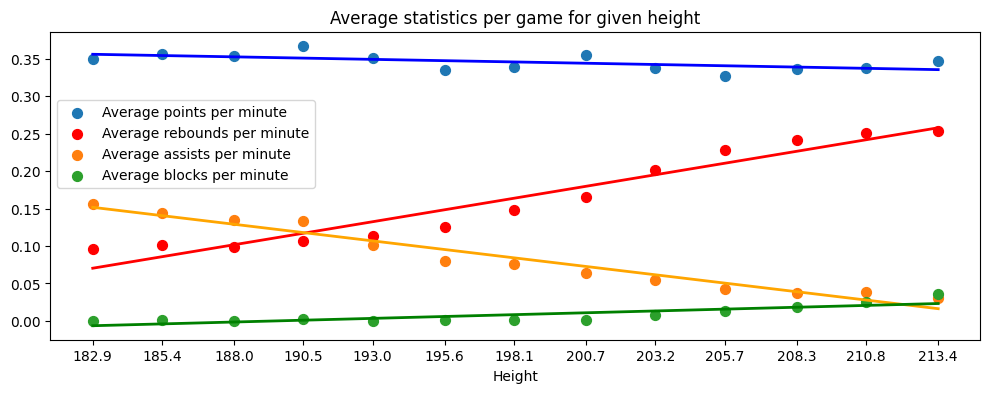

In [44]:
fig, ax = plt.subplots(figsize=(12,4))

ax.scatter(points_to_height_per_minute.index, points_to_height_per_minute.values, label='Average points per minute',  marker='.', s=200)
ax.scatter(rebounds_to_height_per_minute.index, rebounds_to_height_per_minute.values, label='Average rebounds per minute',  marker='.', s=200, color='red')
ax.scatter(assists_to_height_per_minute.index, assists_to_height_per_minute.values, label='Average assists per minute',  marker='.', s=200)
ax.scatter(blocks_to_height_per_minute.index, blocks_to_height_per_minute.values, label='Average blocks per minute',  marker='.', s=200)
ax.set_title('Average statistics per game for given height')
ax.set_xlabel('Height')
ax.set_xticks(average_assists_to_height.index)

model_lin = LinearRegression()
X = points_to_height_per_minute.index.values
model_lin.fit(X.reshape(-1,1), points_to_height_per_minute.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='blue')

model_lin = LinearRegression()
X = rebounds_to_height_per_minute.index.values
model_lin.fit(X.reshape(-1,1), rebounds_to_height_per_minute.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='red')

model_lin = LinearRegression()
X = assists_to_height_per_minute.index.values
model_lin.fit(X.reshape(-1,1), assists_to_height_per_minute.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='orange')

model_lin = LinearRegression()
X = blocks_to_height_per_minute.index.values
model_lin.fit(X.reshape(-1,1), blocks_to_height_per_minute.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='green')

plt.legend(loc='upper left', bbox_to_anchor=(0, 0.8))
plt.show()

Zgodnie z przewidywaniami, wzrost jest silnie skorelowany z liczbą asyst i zbiórek na mecz - im wyższy jest zawodnik, tym mniej asyst wykonuje, a więcej zbiórek. Rośnie także liczba bloków, które są najrzadszymi ze wymienionych statystyk - najwyżsi zawodnicy wykonują ok. 0.05 bloków na minutę, ponad 5 razy więcej niż najniżsi zawodnicy (w perspektywie sezonu jest to różnica mniej więcej 5 do 30 bloków). Z wykresu nie wynika natomiast, aby istniała jakakolwiek zależność między wzrostem a średnim dorobkiem punktowym - dla wszystkich wzrostów średnia liczba punktów na minutę utrzymuje się na poziomie ok. 0.35, bardzo małe jest także średnie odchylenie standardowe.

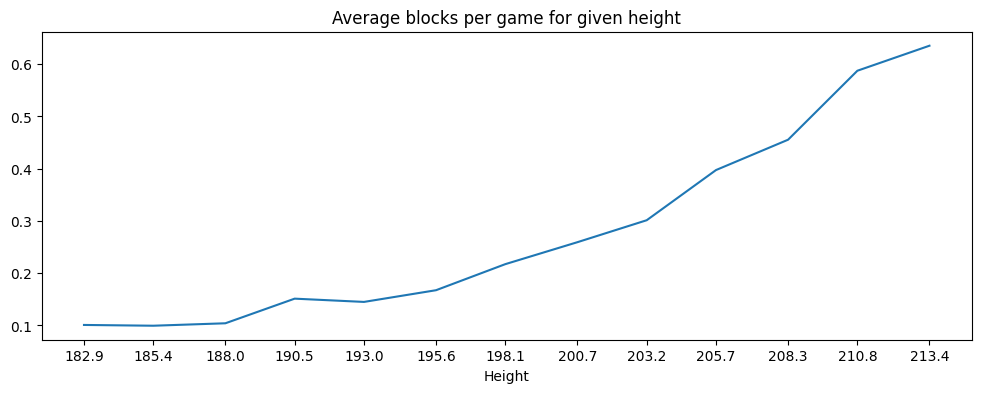

In [52]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(average_blocks_to_height.index, average_blocks_to_height.values, label='Average blocks per game',)
ax.set_title('Average blocks per game for given height')
ax.set_xlabel('Height')
ax.set_xticks(average_blocks_to_height.index)

plt.show()

    Zależność skuteczności rzutów od wzrostu

Centrzy stojący pod koszem mają zazwyczaj użytkową technikę rzutu - umieją umieścić piłkę w koszu z bliskiej odległości, jednak dalsze rzuty zaczynają być kłopotliwe, gdyż wymagają odpowiedniej i wytrenowanej formy rzutu, której centrzy zazwyczaj nie mają. Tę hipotezę potwierdza poniższy wykres.

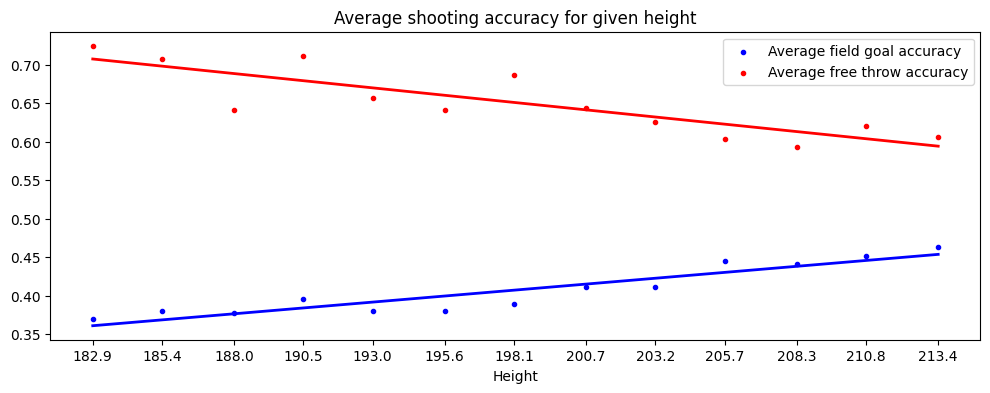

In [51]:
fig, ax = plt.subplots(figsize=(12,4))

field_goals_accuracy_to_height = pd.pivot_table(all_seasons_totals, values='FG%', index='Player', columns='HT')
field_goals_accuracy_to_height = get_normalized_dataframe(field_goals_accuracy_to_height).mean()

free_throw_accuracy_to_height = pd.pivot_table(all_seasons_totals, values='FT%', index='Player', columns='HT')
free_throw_accuracy_to_height = get_normalized_dataframe(free_throw_accuracy_to_height).mean()

ax.scatter(field_goals_accuracy_to_height.index, field_goals_accuracy_to_height.values, label='Average field goal accuracy',  marker='.', color='blue')
ax.scatter(free_throw_accuracy_to_height.index, free_throw_accuracy_to_height.values, label='Average free throw accuracy',  marker='.', color="red")
ax.set_title('Average shooting accuracy for given height')
ax.set_xlabel('Height')
ax.set_xticks(free_throw_accuracy_to_height.index)

model_lin = LinearRegression()
X = field_goals_accuracy_to_height.index.values
model_lin.fit(X.reshape(-1,1), field_goals_accuracy_to_height.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='blue')

model_lin = LinearRegression()
X = free_throw_accuracy_to_height.index.values
model_lin.fit(X.reshape(-1,1), free_throw_accuracy_to_height.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='red')

plt.legend()
plt.show()

Jak widać, wraz ze wzrostem maleje średnia skuteczność rzutów osobistych, rośnie natomiast skuteczność rzutów z gry, co potwierdza postawioną hipotezę. Można też zauważyć, że odchylenie standardowe jest dużo mniejsze dla skuteczności rzutów z gry, co sugerowałoby, że istnieje między nią ścisła zależność ze wzrostem. 

Ostatnia hipoteza jest najbardziej oczywista - im przeciętny zawodnik jest wyższy, tym rzadziej będzie oddawał rzuty za trzy punkty. Zostało już powiedziane, że centrzy dysponują zazwyczaj użytkową techniką rzutu, przystosowaną do odległości 0-3 metry od kosza. Tacy zawodnicy nie mają więc zazwyczaj żadnego powodu do oddania rzutu za 3 punkty, chyba że kończy się czas na wykonanie akcji i nie ma żadnego innego rozwiązania.

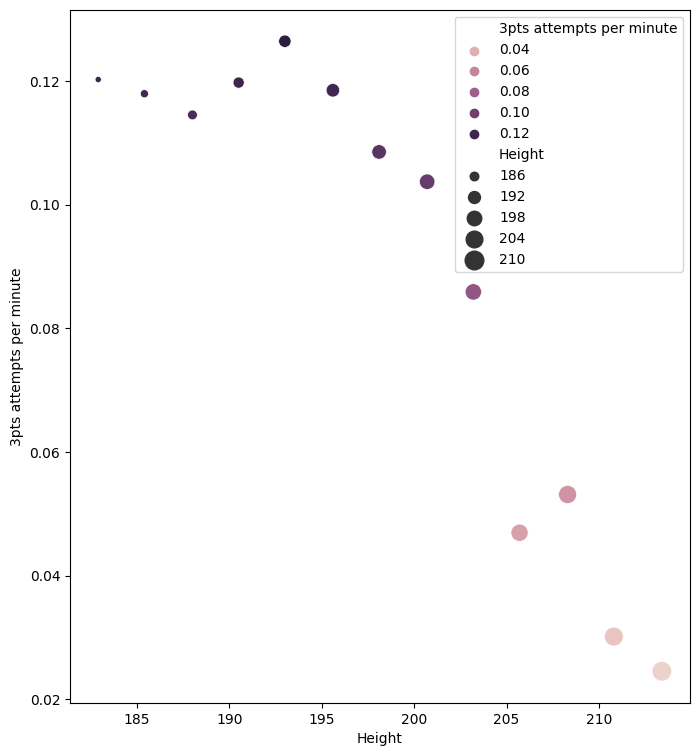

In [53]:
three_pointers_attempts_to_height = pd.pivot_table(all_seasons_per_minute, values='3PA', index='Player', columns='HT')
three_pointers_attempts_to_height = get_normalized_dataframe(three_pointers_attempts_to_height).mean()
three_pointers_attempts_to_height = pd.DataFrame(three_pointers_attempts_to_height, columns=['3pts attempts per minute'])
three_pointers_attempts_to_height.index.name = 'Height'

plt.figure(figsize=(8,9))
sns.scatterplot(
    x='Height',
    y="3pts attempts per minute",
    data=three_pointers_attempts_to_height,
    hue="3pts attempts per minute",
    size='Height',
    sizes=(20, 200),
)
plt.legend(loc='upper right')
plt.show()



Średnia liczba prób rzutów maleje gwałtownie od ok. 195 centymetrów. Dla zawodników niższych liczba utrzymuje się na mniej więcej stałym poziomie równym 0.12 prób na minutę.

    Klasyfikacja zawodników na podstawie wzrostu

Zostało już pokazane, że istnieją zależności między wzrostem zawodników a liczbą zbiórek, asyst i bloków na mecz, skutecznością rzutów osobistych i z pola oraz liczbą prób rzutów za 3 punkty. Korzystając z kombinacji tych parametrów, z dużą skutecznością można oszacować wzrost zawodnika.

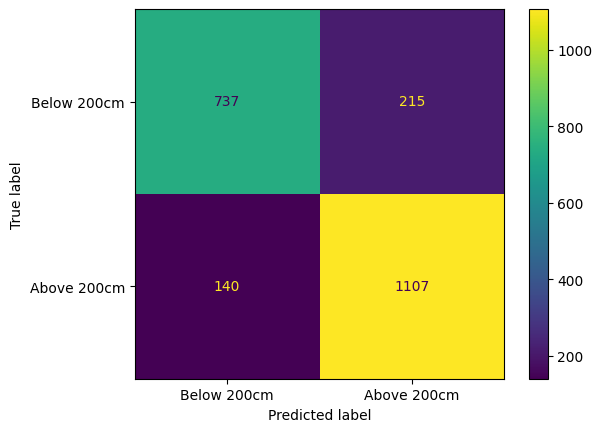

Accuracy: 0.8385629831741701
Sensitivity: 0.8877305533279871
Specificity: 0.7741596638655462


In [54]:
from sklearn.metrics import accuracy_score

X = all_seasons_per_game[['FG%', '3PA', 'FT%', 'RPG', 'BPG', 'APG']].values.tolist()
y = [0 if ht < 200 else 1 for ht in all_seasons_per_game['HT'].values.tolist()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_svm = SVC(kernel='rbf')

sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

_svm.fit(X_train, y_train)
y_pred = _svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[_svm.classes_])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
   display_labels=["Below 200cm", "Above 200cm"],
)
disp.plot()

plt.show()

accuracy = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Specificity = tn / (tn + fp)
Sensitivity = tp / (tp + fn)

print("Accuracy:", accuracy)
print("Sensitivity:", Sensitivity)
print("Specificity:", Specificity)

Powyższy rysunek ukazuje tablicę pomyłek analizowanego modelu dla wcześniej wymienionych parametrów. Podział polegał na określeniu, czy zawodnik ma więcej czy mniej niż 2 metry.

Dokładność klasyfikacji wyniosła 0.839. Można więc stwierdzić, że na podstawie serii przedstawionych parametrów decyzyjnych można z niemal 85% pewnością określić, czy zawodnik ma mniej czy więcej niż 200cm.

Innymi interesującymi wartościami oceniającymi wyniki testu jest czułość i swoistość.

Czułość określa, z jaką dokładnością model był stanie poprawnie sklasyfikować pozytywnego zawodnika, a więc zawodnika ze wzrostem powyżej 200cm. Z kolei swoistość mówi o dokładności modelu w klasyfikacji zawodników negatywnych, których wzrost nie przekraczał 200 cm.

W wynikowej tablicy pomyłek czułość wyniosła aż 88.77\%. Gdy więc dochodziło do analizy zawodnika mierzącego więcej niż 2 metry, model w niemal 90\% był w stanie poprawnie go sklasyfikować. Klasyfikacja zawodników niższych wypadła nieco gorzej, gdyż swoistość modelu wyniosła 77.42\%.

Przedstawione wyniki dotyczyły kolektywnej analizy sześciu parametrów. Pozostaje odpowiedzieć na pytanie - który z nich w sposób dominujący cechuje wysokich zawodników oraz jak dokładnie da się określić przedział wzrostu koszykarza na ich podstawie.

In [55]:
from sklearn.metrics import accuracy_score

def show_classification_scores_for_height(height):
    attributes = ['FG%', '3PA', 'FT%', 'RPG', 'BPG', 'APG']
    y = [0 if ht < height else 1 for ht in all_seasons_per_game['HT'].values.tolist()]

    accuracy_scores = []
    sensitivity_scores = []
    specificity_scores = []
    for attribute in attributes:
        X = all_seasons_per_game[[attribute]].values.tolist()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        sc = StandardScaler()
        sc.fit(X_train)
        X_train, X_test = sc.transform(X_train), sc.transform(X_test)
            
        svm = SVC(kernel='rbf')
        svm.fit(X_train, y_train)
            
        y_pred = svm.predict(X_test)
            
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(round(accuracy, 2))
            
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        Sensitivity = tp / (tp + fn)
        sensitivity_scores.append(round(Sensitivity, 2))

        Specificity = tn / (tn + fp)
        specificity_scores.append(round(Specificity, 2))

    print(f"{height}: {accuracy_scores}")
    print(f"{height}: {sensitivity_scores}")
    print(f"{height}: {specificity_scores}")
    scores = {'Accuracy': accuracy_scores, 'Sensitivity': sensitivity_scores, 'Specificity': specificity_scores}
    x = np.arange(len(attributes))
    width = 0.25
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(15,5))

    for attribute, score in scores.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, score, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_ylabel('Score')
    ax.set_title(f'Scores by attributes for {str(height)}cm')
    ax.set_xticks(x + width, attributes)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1)
        
    plt.show()

200: [0.67, 0.69, 0.62, 0.66, 0.7, 0.68]
200: [0.69, 0.59, 0.78, 0.65, 0.69, 0.84]
200: [0.64, 0.83, 0.42, 0.67, 0.72, 0.47]


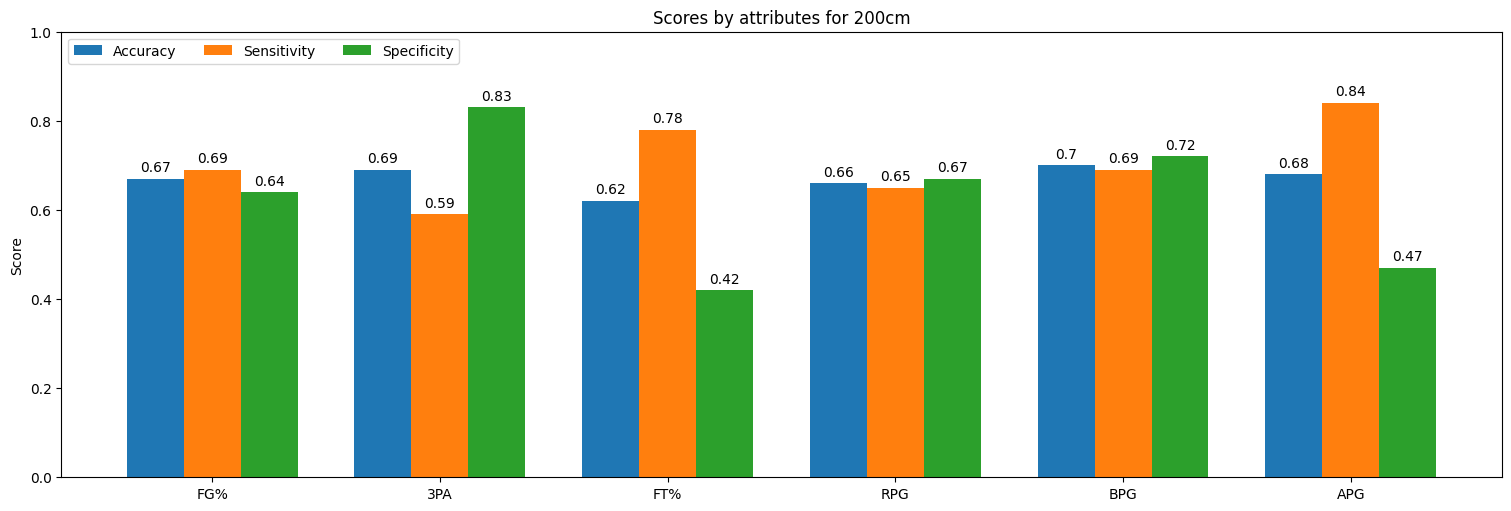

In [68]:
show_classification_scores_for_height(200)

205: [0.71, 0.78, 0.66, 0.71, 0.76, 0.66]
205: [0.41, 0.62, 0.3, 0.36, 0.49, 0.48]
205: [0.89, 0.88, 0.87, 0.92, 0.92, 0.77]


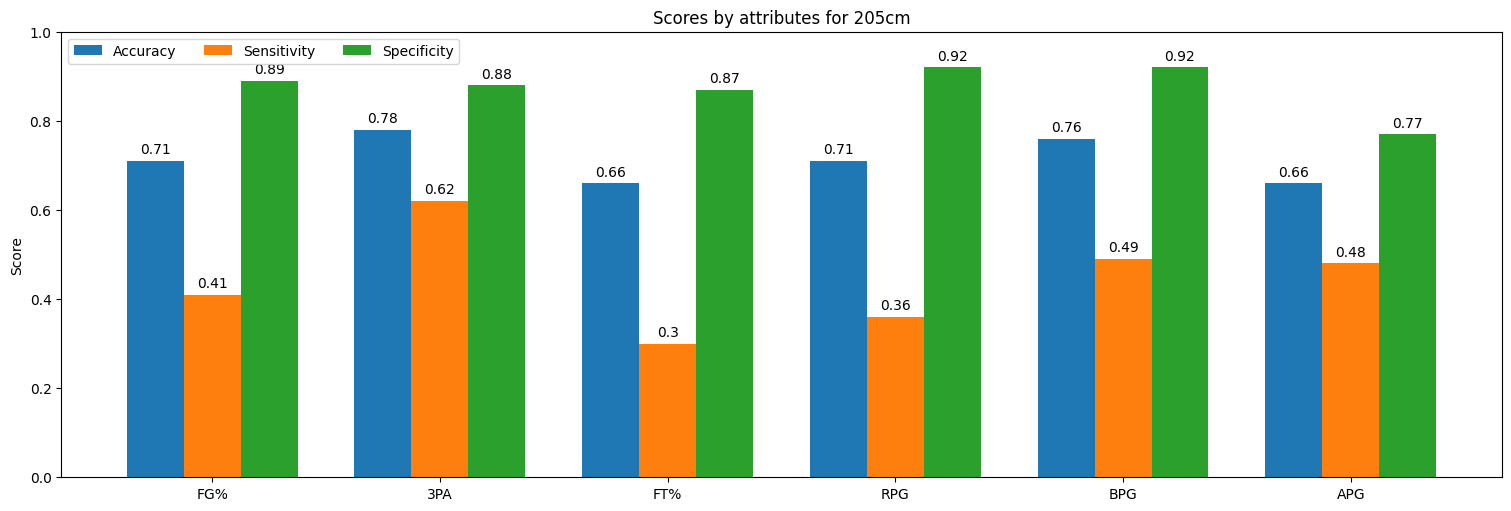

In [69]:
show_classification_scores_for_height(205)

Powyższe wykresy obrazują wyniki klasyfikacji zawodników. Wykres pierwszy dzielił zawodników na niższych i wyższych niż 200cm, a drugi na zawodników niższych i wyższych niż 205cm. W obu przypadkach zawodnicy byli kolejno klasyfikowani na podstawie pojedynczego parametru. Wykresy ukazują wartości dokładności, czułości i swoistości modelów dla danych parametrów.

Pierwszym z wniosków jest fakt, że model klasyfikujący zawodników na wzrost 200cm ma mniejszą średnią dokładność, wynoszącą 0.67 dla pierwszego modelu i 0.71 dla drugiego. Jest to oczywiście spowodowane faktem, że im wyższa jest granica wzrostu, tym łatwiej jest przydzielić zawodnika do jednej z grup. Dużo wyraźniej widać różnicę między zawodnikami mierzącymi 230cm i niższymi, niż między zawodnikami mierzącymi 200cm i niższymi.

Druga obserwacja dotyczy wartości czułości i swoistości w obu modelach. Średnia swoistość jest dużo wyższa w drugim modelu klasyfikacji, podczas gdy jego średnia czułość jest dużo niższa.

Im wyższa jest granica wzrostu zawodników, tym łatwiej stwierdzić, że zawodnik nie klasyfikuje się jako zawodnik wysoki. Mówi o tym zwiększona średnia swoistość w drugim modelu - zawodnik niemierzący ponad 205cm może być łatwiej wykryty, skoro większa jest różnica parametrów klasyfikujących zawodników mierzących 205cm w porównaniu do zawodników niższych.

Mniejsza średnia czułość oznacza, że trudniej jest sklasyfikować zawodnika mierzącego ponad 205cm niż zawodnika mierzącego ponad 200cm, a więc że różnica między zawodnikami mierzącymi 200 i 205cm nie jest tak wyraźna, jak różnica między zawodnikami mierzącymi ponad 200cm i mniej niż 200cm.

Na podstawie wykresów można więc stwierdzić, że parametrem najdokładniej klasyfikującym zawodników na grupy wzrostowe więcej/mniej niż 200cm jest liczba prób rzutów za trzy punkty (średnia dokładność 0.735) oraz liczba bloków na mecz (średnia dokładność 0.73). Gdy chodzi o czułość wykrywania zawodników wysokich, najlepiej sprawdza się liczba asyst na mecz (średnia czułość 0.66), oraz ponownie liczba prób rzutów za trzy punkty i liczba bloków na mecz (czułości 0.605 i 0.59). Te dwa parametry ponownie okazują się dominujące przy wykrywaniu zawodników niższych, ze średnią swoistością 0.855 dla rzutów za 3 punkty i 0.82 dla liczby bloków.

Im wyższa będzie granica wzrostu tym korzystniejsza będzie osiągnięta dokładność i swoistość modelu. Z kolei czułość modelu będzie malała wraz z przesuwaniem granicy wzrostu do góry.

    Wnioski